# Dynamic Programming

We will use the environments defined in the previous chapter.

## Policy Evaluation (Prediction)

With the reward $r$ we obtain the value update function

\begin{align}
v_{k+1}(s) = \sum_a \pi(a|s) \sum_{s',r} p\left( s',r\,|\, s,a \right) \left[ r+\gamma v_k(s') \right]
\end{align}

In [1]:
# assuming the environment is determinitic (which means: there is only one reward and state possible prior given state and action)

import numpy as np
import dm_env


def policy_evaluation_first_approach(policy: np.array, value: np.array, states_count: int, action_count: int,
                      environment: dm_env.Environment, terminal_delta: float = 0.1):
    """
    Arguments:
    policy: state x action
    value: state
    """
    assert policy.shape == (states_count, action_count)
    assert value.shape == (states_count,)

    while True:
        max_delta = 0
        for state in range(states_count):
            delta = 0
            for action in range(action_count):
                timestep = environment.step(action)
                r = timestep.reward
                next_state = timestep.observation
                discount = timestep.discount
                delta += policy[state, action]*(r + discount*value[next_state])

            value[state] = delta

        value[state] += delta
        max_delta = max(max_delta, delta)

        if max_delta < terminal_delta:
            break


## Policy Iteration (Policy Improvement)

Policy iteration is the alternating policy evaluation (**E**) and policy improvement (**I**) chain:

\begin{align}
\pi_0 \overset{\text{E}}{\longrightarrow} v_{\pi_0} 
\overset{\text{I}}{\longrightarrow} \pi_1 \overset{\text{E}}{\longrightarrow} v_{\pi_1}
\overset{\text{I}}{\longrightarrow} \pi_2 \overset{\text{E}}{\longrightarrow} v_{\pi_2}
\overset{\text{I}}{\longrightarrow}\cdots
\overset{\text{I}}{\longrightarrow} \pi_* \overset{\text{E}}{\longrightarrow} v_*
\end{align}

In [2]:
from typing import Tuple, Sequence
import numpy as np
import dm_env


def policy_evaluation(policy: np.array, value: np.array, environment: dm_env.Environment,
                      terminal_delta: float = 0.1, max_steps: int = 50) -> None:
    """
    Arguments:
    policy: state
    value: state
    """

    states = list(environment.available_states)
    assert value.shape == (len(states),)
    assert policy.shape == (len(states),)
    assert policy.dtype == int

    for _ in range(max_steps):
        max_delta = 0

        for state_index, state in enumerate(states):
            v = value[state_index]
            action = policy[state_index]
            # as p(s',r|s,a) is a dirac distribution for deterministic environment we just call the step
            environment.state = state
            timestep = environment.step(action)
            r = timestep.reward
            next_state = timestep.observation
            next_state_index = environment.state_index(next_state)

            discount = timestep.discount
            # print(f"{state_index}: {value[state_index]} <- {r + discount*value[next_state_index]} = {r} + {discount} * {value[next_state_index]}")
            value[state_index] = r + discount*value[next_state_index]
            delta = abs(value[state_index] - v)
            max_delta = max(max_delta, delta)

        if max_delta < terminal_delta:
            return

    raise TimeoutError(f"max delta: {max_delta} terminal_delta: {terminal_delta}")


def policy_improvement(policy: np.array, value: np.array, action_count: int,
                       environment: dm_env.Environment) -> bool:
    """
    Arguments:
    policy: state
    value: state

    Returns if the policy is stable
    """

    states = list(environment.available_states)
    assert value.shape == (len(states),)
    assert policy.shape == (len(states),)
    assert policy.dtype == int

    policy_stable = True
    for state_index, state in enumerate(states):
        old_action = policy[state_index]
        candidates = []
        for action in range(action_count):
            environment.state = state
            timestep = environment.step(action)
            r = timestep.reward
            next_state = timestep.observation
            next_state_index = environment.state_index(next_state)
            discount = timestep.discount

            candidates.append(r + discount*value[next_state_index])

        policy[state_index] = np.argmax(candidates)

        policy_stable &= policy[state_index] == old_action

    return policy_stable


def policy_iteration(environment: dm_env.Environment, action_count: int, seed: int = 1) -> Sequence[Tuple[np.array, np.array]]:
    """Returns a sequence of tuples (value, policy)"""

    rng = np.random.RandomState(seed)
    state_count = len(list(environment.available_states))

    value = rng.uniform(0., 1., (state_count,))
    policy = rng.randint(0, action_count-1, (state_count,))

    while True:
        policy_evaluation(policy=policy, value=value, environment=environment)
        yield value, policy
        if policy_improvement(policy=policy, value=value, action_count=action_count, environment=environment):
            break


Iteration: 0


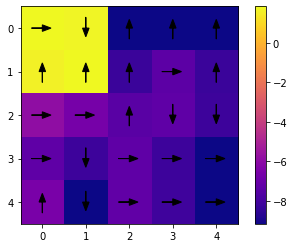

Iteration: 1


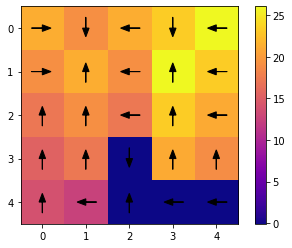

Iteration: 2


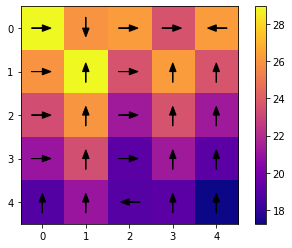

Iteration: 3


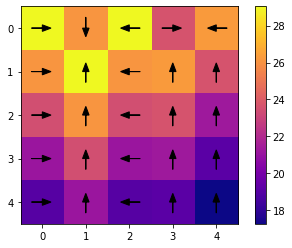

Iteration: 4


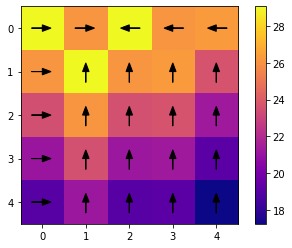

Solution from the textbook


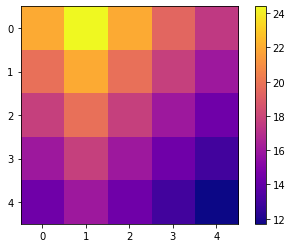

In [3]:
import nbimporter
import matplotlib.pyplot as plt

from chapter_3.finite_markov_decision_processes import GridWorld, Position, BeamAction


def draw_2d_policy(policy: np.array, width: int):
    """
    Draws value and policy maps

    Assuming that policy is the index of the sorted array
    containing the names of the four cardinal direction.
    """

    dirs = {
        'north': (0, -1),
        'south': (0, 1),
        'east': (1, 0),
        'west': (-1, 0),
    }
    dir_names = sorted(list(dirs.keys()))

    def draw_arrow(x, y, action, scaling=0.25):

        dx, dy = dirs[action]

        plt.arrow(x-dx*scaling, y-dy*scaling, dx*scaling, dy*scaling, fc="k",
                  ec="k", head_width=0.15, head_length=0.2)

    for i, p in enumerate(policy):
        iy = i % width
        ix = i // width

        draw_arrow(ix, iy, dir_names[p])


def draw_2d_value(value: np.array, width: int):
    matrix = np.reshape(value, (width, -1))
    # matrix = np.rot90(matrix)
    matrix = np.transpose(matrix)
    plt.imshow(matrix, cmap='plasma')


def draw_2d(value: np.array, policy: np.array, width: int):
    """
    Draws value and policy maps

    Assuming that policy is the index of the sorted array
    containing the names of the four cardinal direction.
    """

    draw_2d_value(value=value, width=width)
    draw_2d_policy(policy=policy, width=width)

    plt.colorbar()
    plt.show()


WIDTH = 5
HEIGHT = 5


beam_actions = {
    Position(1, 0): BeamAction(1, 4, reward=10.),
    Position(3, 0): BeamAction(3, 2, reward=5.),
}

env = GridWorld(width=WIDTH, height=HEIGHT, beam_actions=beam_actions)

for iteration, (value, policy) in enumerate(policy_iteration(environment=env, action_count=4)):
    print(f"Iteration: {iteration}")
    draw_2d(value, policy, WIDTH)

# text book solution
optimal_value = np.array([[22., 24.4, 22.0, 19.4, 17.5],
                          [19.8, 22.0, 19.8, 17.8, 16.0],
                          [17.8, 19.8, 17.8, 16.0, 14.4],
                          [16.0, 17.8, 16.0, 14.4, 13.0],
                          [14.4, 16.0, 14.4, 13.0, 11.7]])


print("Solution from the textbook")
draw_2d_value(np.transpose(optimal_value), WIDTH)
plt.colorbar()
plt.show()


## Value Iteration

Policy evaluation is stopped after just one sweep.